#### Implement the baseline algos here

In [1]:
import sys; sys.path.insert(0, "../"); from utils import *
import pickle

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from pde_diff import *
import robust_PDE_FIND
from robust_PDE_FIND import TrainSTRidge, compute_err, print_pde, RobustPCA, Robust_LRSTR
import scipy.io as sio

You can use npar for np.array
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['diff', 'save']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# Loading the KS sol
data = pickle_load("../deephpms_data/KS_simple3.pkl")

t = data['t']; time_dims = t.shape[0]
x = data['x']; spatial_dims = x.shape[0]
total_points = time_dims*spatial_dims
print("Total data points:", total_points)

X, T = np.meshgrid(x, t)
Exact = data['u'].T
u = Exact

Loaded from ../deephpms_data/KS_simple3.pkl
Total data points: 62464


In [3]:
X.shape == T.shape == Exact.T.shape

True

<ipython-input-4-92c3c6bcfb44>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig1.gca(projection='3d')


Text(0.5, 0, 't')

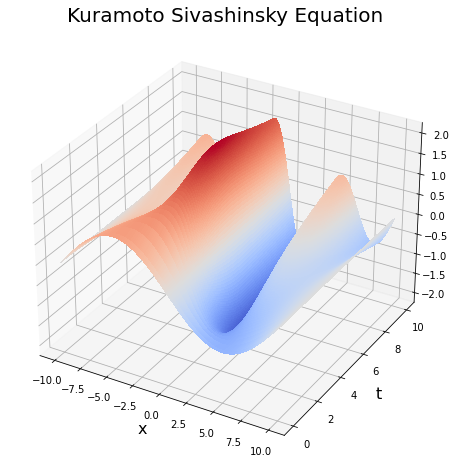

In [4]:
fig1 = figure()
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(X, T, u.T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title('Kuramoto Sivashinsky Equation', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)

#### STR

In [5]:
dt = t[1]-t[0]
dx = x[2]-x[1]
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=5, P=5, time_diff = 'FD', space_diff = 'FD')

In [6]:
Ut.shape[0] == total_points

True

In [7]:
w = TrainSTRidge(R,Ut,10**-5,50)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_small_KS/robust_PDE_FIND.py:845: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]
/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_small_KS/robust_PDE_FIND.py:890: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y))[0]
/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_small_KS/robust_

PDE derived using STRidge
u_t = (-0.482219 +0.000000i)uu_{x}
    + (-0.482604 +0.000000i)u_{xx}
    + (-0.482780 +0.000000i)u_{xxxx}
   


In [8]:
errs = 100*(npar([-0.482219, -0.482604, -0.482780])+1)
errs.mean(), errs.std()

(51.746566666666666, 0.023426528172613682)

#### STR + noise (Fail)

In [9]:
numpy.random.seed(0)
un = u + 0.01*std(u)*np.random.randn(u.shape[0],u.shape[1])

In [10]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=5, P=5, 
                                 time_diff = 'poly', space_diff = 'poly', 
                                 width_x = 20, width_t = 20, deg_x = 6)

print(Utn.shape[0] == total_points)

# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,50)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

False
PDE derived using STRidge
u_t = (0.000795 +0.000000i)u^2u_{xx}
   


#### DLrSR

In [11]:
u_in = u

Z, E1 = RobustPCA(u_in, lam_2 = 0.1)

ZUtn, ZRn, rhs_des = build_linear_system(Z, dt, dx, D=5, P=5, 
                                 time_diff = 'poly', space_diff = 'poly', 
                                 width_x = 20, width_t = 20, deg_x = 6)

iteration:1, err:1955.8732531322378, nc_norm:541.5461572548405 eta1:0.006168588152288427
iteration:50, err:0.05231647739299204, nc_norm:504.6944984175893 eta1:0.6583052947824773
iteration:100, err:0.0005260252470477819, nc_norm:302.5953039966659 eta1:77.27902000973455
iteration:144, err:8.94185844465564e-06, nc_norm:300.8851786438278 eta1:5120.82286110939


In [12]:
double_width = 0
for n in range(0, 101):
    if ZUtn.shape[0] == (spatial_dims-n)*(time_dims-n):
        double_width = n
        nx = spatial_dims-n
        nt = time_dims-n
        print(double_width); break

40


In [13]:
# Solve with DLrSR
Utn1 = np.reshape(ZUtn, (nx,nt))
w, X, E2=Robust_LRSTR(ZRn, Utn1, rhs_des, lam_1 = 1e-5, lam_3 = 0.15, lam_4 = 1, d_tol = 1)
print_pde(w, rhs_des)

iteration:1, err:60.64279908220069, nc_norm:28.814740995979097 eta2:0.17614690735215427
u_t = 
u_t = (-0.254848 +0.000000i)uu_{x}
    + (-0.255692 +0.000000i)u_{xx}
    + (-0.254883 +0.000000i)u_{xxxx}
   
u_t = (-0.339257 +0.000000i)uu_{x}
    + (-0.340353 +0.000000i)u_{xx}
    + (-0.339282 +0.000000i)u_{xxxx}
   
u_t = (-0.324015 +0.000000i)uu_{x}
    + (-0.325091 +0.000000i)u_{xx}
    + (-0.324061 +0.000000i)u_{xxxx}
   
u_t = (-0.309250 +0.000000i)uu_{x}
    + (-0.310295 +0.000000i)u_{xx}
    + (-0.309308 +0.000000i)u_{xxxx}
   
u_t = (-0.307894 +0.000000i)uu_{x}
    + (-0.308932 +0.000000i)u_{xx}
    + (-0.307949 +0.000000i)u_{xxxx}
   
u_t = (-0.309044 +0.000000i)uu_{x}
    + (-0.310081 +0.000000i)u_{xx}
    + (-0.309095 +0.000000i)u_{xxxx}
   
u_t = (-0.309322 +0.000000i)uu_{x}
    + (-0.310360 +0.000000i)u_{xx}
    + (-0.309374 +0.000000i)u_{xxxx}
   
u_t = (-0.309282 +0.000000i)uu_{x}
    + (-0.310320 +0.000000i)u_{xx}
    + (-0.309334 +0.000000i)u_{xxxx}
   
u_t = (-0.309263 

In [14]:
errs = 100*(npar([-0.309260, -0.310297, -0.309311])+1)
errs.mean(), errs.std()

(69.03773333333334, 0.04772800249562518)

#### DLrSR + noise (Normal distributed noise) Fail similar to STR

In [15]:
u_in = un

Z, E1 = RobustPCA(u_in, lam_2 = 0.1)

ZUtn, ZRn, rhs_des = build_linear_system(Z, dt, dx, D=5, P=5, 
                                 time_diff = 'poly', space_diff = 'poly', 
                                 width_x = 20, width_t = 20, deg_x = 6)

iteration:1, err:1954.2470974580463, nc_norm:582.2638825893092 eta1:0.006168511812374373
iteration:50, err:0.5192111503618857, nc_norm:526.4721377524788 eta1:0.6582971478664594
iteration:80, err:9.251826834266246e-06, nc_norm:334.4744872780399 eta1:11.486891745582477


In [16]:
# Solve with DLrSR
Utn1 = np.reshape(ZUtn, (nx,nt))
w, X, E2=Robust_LRSTR(ZRn, Utn1, rhs_des, lam_1 = 1e-5, lam_3 = 0.15, lam_4 = 1, d_tol = 1)
print_pde(w, rhs_des)

iteration:1, err:60.44584731126553, nc_norm:34.416510708849565 eta2:0.17591065963142133
u_t = 
u_t = (-0.039721 +0.000000i)u
    + (0.003615 +0.000000i)u^5
    + (-0.071109 +0.000000i)u_{xx}
    + (0.024135 +0.000000i)u^2u_{xx}
   
u_t = (-0.052711 +0.000000i)u
    + (0.004746 +0.000000i)u^5
    + (-0.093665 +0.000000i)u_{xx}
    + (0.031593 +0.000000i)u^2u_{xx}
   
u_t = (-0.050492 +0.000000i)u
    + (0.004591 +0.000000i)u^5
    + (-0.090327 +0.000000i)u_{xx}
    + (0.030642 +0.000000i)u^2u_{xx}
   
u_t = (-0.048267 +0.000000i)u
    + (0.004413 +0.000000i)u^5
    + (-0.086706 +0.000000i)u_{xx}
    + (0.029510 +0.000000i)u^2u_{xx}
   
u_t = (-0.048017 +0.000000i)u
    + (0.004381 +0.000000i)u^5
    + (-0.086144 +0.000000i)u_{xx}
    + (0.029283 +0.000000i)u^2u_{xx}
   
u_t = (-0.048166 +0.000000i)u
    + (0.004386 +0.000000i)u^5
    + (-0.086286 +0.000000i)u_{xx}
    + (0.029296 +0.000000i)u^2u_{xx}
   
u_t = (-0.048203 +0.000000i)u
    + (0.004387 +0.000000i)u^5
    + (-0.086323 +0.00

#### Notes on the AAAI'20 paper
    - The algo needs grid. Not possible to run the algo on freely distributed data points.
    - Assume strictly sparse-distributed noise.
    - It is not clear how to tune the lagrange multiplier hyper parameters so that the optimal true PDE is obtained.
    - The PDE solution and the pde diff features are not learned or updated joinly, hence, the sub-optimal equation is discovered, especially in the noisy case.